In [132]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import pyarrow as pa
import pyarrow.parquet as pq

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator

!date
!whoami
!pwd

Tue Oct 14 12:32:24 PDT 2025
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# V&V List


* Positive BBBM tests result in 90% treatment initiation and 10% no treatment

* 10% of transitions to Full treatment effect status are by simulants who discontinue treatment

* Full/Waning durations are accurate (use person-time ratios between states?)

* “In treatment/waiting for treatment” duration is accurate (use person-time ratios between states?)

* Interactive sim verification spot checking a simulant’s durations in
  treatment statuses as they move through BBBM test negative, Full
  treatment effect, Waning treatment effect, No treatment effect
  statuses (for both completed and discontinued treatments)

* Check hazard ratio of treated to not treated for hazard rate from BBBM
  to MCI

# Find data

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model7.0/model_spec/2025_10_09_17_56_46/results

In [2]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [3]:
# Results directory containing model 6 results for all locations
!ls -halt results/model7.0/model_spec/2025_10_09_17_56_46/results

total 614M
drwxrwsr-x 5 sbachmei IHME-Simulationscience 4.5K Oct  9 20:55 ..
drwxrwsr-x 2 sbachmei IHME-Simulationscience 6.5K Oct  9 20:54 .
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  12M Oct  9 20:54 counts_newly_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  11M Oct  9 20:53 person_time_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 7.1M Oct  9 20:53 counts_bbbm_tests.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  17M Oct  9 20:52 transition_count_alzheimers_disease_and_other_dementias.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 194M Oct  9 20:52 ylds.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 106M Oct  9 20:51 person_time_treatment.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  75M Oct  9 20:50 person_time_ever_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 9.0M Oct  9 20:48 counts_new_simulants.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  23

In [4]:
!ls results/model7.0/model_spec/2025_10_09_17_56_46/

__pycache__		   keyspace.yaml	     requirements.txt
branches.yaml		   logs			     results
finished_sim_metadata.csv  model_specification.yaml  settings.py


In [209]:
locations = [
    'United States of America',
    # 'Brazil',
    'China',
    # 'Germany',
    # 'Israel',
    'Japan',
    # 'Spain',
    'Sweden',
    # 'Taiwan (Province of China)',
    # 'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations} | {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# # Select a subset of locations to draw plots for
# locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

model_number = '7.0' # Artifacts are stored here
run_subdirectories = [
    'results/model7.0/model_spec/2025_10_09_17_56_46/',
]
run_dirs = [project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# # Option 1: One results directory per location
# location_to_results_dir = {
#     loc: path for loc, path in zip(locations, results_dirs)}

# Option 2: All locations in one results directory
location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
location_to_artifact_path

{'United States of America': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf',
 'China': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/china.hdf',
 'Japan': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/japan.hdf',
 'Sweden': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/sweden.hdf'}

In [210]:
location_to_results_dir

{'all': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model7.0/model_spec/2025_10_09_17_56_46/results/'}

# Define some ordered Categorical dtypes

In [211]:
# Order locations lexicographically
location_dtype = pd.CategoricalDtype(sorted(locations), ordered=True)

# Order age groups chronologically
age_groups = [f'{age}_to_{age + 4}' for age in range(25, 95, 5)] + ['95_plus']
age_group_dtype = pd.CategoricalDtype(age_groups, ordered=True)

# Order scenarios by complexity
scenarios = ['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
scenario_dtype = pd.CategoricalDtype(scenarios, ordered=True)

colname_to_categorical_dtype = {
    'location': location_dtype,
    'age_group': age_group_dtype,
    'scenario': scenario_dtype,
}

# Load one artifact and define age bins

In [6]:
usa_artifact_path = location_to_artifact_path['United States of America']
usa_art = Artifact(usa_artifact_path)
print(usa_art.load('metadata.locations'))
print(usa_art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		cause_specific_mortality_rate
		excess_mortality_rate
		disability_weight
		restrictions
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [7]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = usa_art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

,age_group_id,age_group_name,age_start,age_end,age_group
4,10,25 to 29,25.0,30.0,25_to_29
5,11,30 to 34,30.0,35.0,30_to_34
6,12,35 to 39,35.0,40.0,35_to_39
7,13,40 to 44,40.0,45.0,40_to_44
8,14,45 to 49,45.0,50.0,45_to_49
9,15,50 to 54,50.0,55.0,50_to_54
10,16,55 to 59,55.0,60.0,55_to_59
11,17,60 to 64,60.0,65.0,60_to_64
12,18,65 to 69,65.0,70.0,65_to_69
13,19,70 to 74,70.0,75.0,70_to_74


# See what the treatment relative risk looks like

Draws should be uniformly distributed in $[0.4, 0.6]$.

In [10]:
treatment_rr = usa_art.load('treatment.relative_risk')
treatment_rr

,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,draw_8,draw_9,...,draw_490,draw_491,draw_492,draw_493,draw_494,draw_495,draw_496,draw_497,draw_498,draw_499
0,0.527516,0.495529,0.464333,0.576056,0.478925,0.458396,0.541982,0.520483,0.53923,0.514836,...,0.485136,0.498684,0.503797,0.432717,0.462276,0.481699,0.569136,0.502568,0.4362,0.512734


# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [8]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Define functions to load simulation output and summarize it for plotting

With the `pyarrow` engine, `pandas.read_parquet()` calls `pyarrow.parquet.read_table()` and
`pyarrow.Table.to_pandas()`. Additional keyword arguments passed to
`pandas.read_parquet()` are passed to `pyarrow.parquet.read_table()`.

https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html#pyarrow.parquet.read_table

https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_pandas

Pyarrow Dictionary arrays are analogous to pandas Categoricals:

https://arrow.apache.org/docs/python/data.html#data-dictionary

Pyarrow data types:

https://arrow.apache.org/docs/python/api/datatypes.html

https://arrow.apache.org/docs/python/generated/pyarrow.types.is_floating.html


Google AI results for "find column names in parquet file":

```python
import pyarrow.parquet as pq

# Replace 'your_file.parquet' with the actual path to your Parquet file
parquet_file_path = 'your_file.parquet'

# Read the Parquet file's schema
parquet_schema = pq.read_schema(parquet_file_path)

# Extract column names
column_names = parquet_schema.names

print(f"Column names in '{parquet_file_path}':")
for name in column_names:
    print(name)
```

In [212]:
ops = VPHOperator()
ops.index_cols.append('location')

def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        # Pass None to skip filtering locations (when None, must also
        # pass assign_location=False or raw=True)
        location_to_artifact_path=location_to_artifact_path,
        colname_to_dtype=colname_to_categorical_dtype,
        drop_superfluous_cols=True, # drop redundant or empty columns
        # Sets the 'read_dictionary' key of kwargs, which is passed to
        # pyarrow.parquet.read_table()
        force_parquet_dictionaries=True,
        force_pandas_categoricals=True,
        aggregate_seeds=True,
        assign_location=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    if raw:
        drop_superfluous_cols = False
        force_parquet_dictionaries = False
        force_pandas_categoricals = False
        aggregate_seeds = False
        assign_location = False

    match location_to_results_dir:
        case {'all': _}:
            all_locations_together = True
        case _:
            all_locations_together = False
    
    if all_locations_together and assign_location and location_to_artifact_path is None:
        raise ValueError(
            "Must provide mapping of artifacts to locations  when" \
            " assign_location=True and all locations are in a single" \
            " results directory"
        )

    dfs = []
    for location, directory in results_dict.items():

        parquet_file_path = Path(directory) / f'{measure}.parquet'
        # Read the Parquet file's schema to get column names and data types
        parquet_schema = pq.read_schema(parquet_file_path)

        if (
            all_locations_together
            and location_to_artifact_path is not None
            and 'artifact_path' in parquet_schema.names
        ):
            # Filter to locations in list
            location_filter = (
                'artifact_path',
                'in',
                list(location_to_artifact_path.values()),
            )
            user_filters = kwargs.get('filters') # Defaults to None
            kwargs['filters'] = add_parquet_AND_filter(
                location_filter, user_filters)

        if force_parquet_dictionaries:
            # Read all columns as dictionaries except those containing 
            # floating point values
            kwargs['read_dictionary'] = [
                col.name for col in parquet_schema
                if not pa.types.is_floating(col.type)]

        # Read the parquet file
        df = pd.read_parquet(parquet_file_path, **kwargs)

        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns (e.g., sub-entity)
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if colname_to_dtype is not None:
            convert_dtypes(df, colname_to_dtype, inplace=True)
        if force_pandas_categoricals:
            convert_to_categorical(df, exclude=colname_to_dtype or {}, inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if assign_location:
            if all_locations_together:
                # Invert the dictionary so we can map artifact paths to
                # locations
                # NOTE: Guaranteed not to be None because
                # assign_location is True
                artifact_path_to_location = {
                    path: loc for loc, path in location_to_artifact_path.items()}
                if 'artifact_path' in df:
                    df['location'] = df['artifact_path'].map(
                        artifact_path_to_location).astype(location_dtype)
                else:
                    # In case the engineers change the DataFrame format
                    # on us...
                    print("'artifact_path' column missing from DataFrame")
            else:
                df['location'] = location
                df['location'] = df['location'].astype(location_dtype)
        dfs.append(df)
    df = pd.concat(dfs)
    return df

def convert_dtypes(df, colname_to_dtype, inplace=False):
    if not inplace:
        df = df.copy()
    for colname, dtype in colname_to_dtype.items():
        if colname in df:
            df[colname] = df[colname].astype(dtype)

    if not inplace:
        return df
    else:
        return None

# TODO: Consider making certain columns ordered Categoricals
def convert_to_categorical(df, exclude=(), inplace=False):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if not inplace:
        df = df.copy()
    for col in df:
        if col not in exclude and df[col].dtype not in ('float', 'category'):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None
    
def add_parquet_AND_filter(new_filter, existing_filters):
    match existing_filters:
        case None:
            # No existing filters -- create a single AND group
            filters = [new_filter]
        case list([tuple((_, _, _)), *_]):
            # Existing filters consist of one AND group -- add the new filter
            filters = [new_filter, *existing_filters]
        case list([list([tuple((_, _, _)), *_]), *_]):
            # Add the filter to each AND group in the outer OR group
            filters = [[new_filter, *and_group] for and_group in existing_filters]
        case _:
            raise ValueError(f"Malformed parquet filter: {existing_filters}")
    # # Alternate version using isinstance()
    # if existing_filters is None:
    #     # No existing filters -- create a single AND group
    #     filters = [new_filter]
    # elif isinstance(existing_filters[0], tuple):
    #     # Existing filters consist of one AND group -- add the new filter
    #     filters = [new_filter, *existing_filters]
    # elif isinstance(existing_filters[0], list):
    #     # Add the filter to each AND group in the outer OR group
    #     filters = [[new_filter, *and_group] for and_group in existing_filters]
    # else:
    #     raise ValueError(f"Malformed parquet filter: {existing_filters}")
    return filters

# NOTE: Need to create ops before defining this function
def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

def print_memory_usage(df):
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB')


()

In [213]:
new_sims = load_sim_output(
    'counts_new_simulants',
    # colname_to_dtype=None,
    # raw=True,
    engine='pyarrow',
    # read_dictionary=['input_draw', 'scenario'],
    # filters=[('event_year', '==', '2025')],
    # assign_location=False,
)
new_sims

,age_group,artifact_path,event_year,input_draw,scenario,sex,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,24,baseline,Female,0.0,Japan
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,24,baseline,Male,1.0,Japan
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,24,bbbm_testing,Female,0.0,Japan
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,24,bbbm_testing,Male,1.0,Japan
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,24,bbbm_testing_and_treatment,Female,0.0,Japan
...,...,...,...,...,...,...,...,...
683995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,258,baseline,Male,0.0,China
683996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,258,bbbm_testing,Female,0.0,China
683997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,258,bbbm_testing,Male,0.0,China
683998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,258,bbbm_testing_and_treatment,Female,0.0,China


In [214]:
new_sims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684000 entries, 0 to 683999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   age_group      684000 non-null  category
 1   artifact_path  684000 non-null  category
 2   event_year     684000 non-null  category
 3   input_draw     684000 non-null  category
 4   scenario       684000 non-null  category
 5   sex            684000 non-null  category
 6   value          684000 non-null  float64 
 7   location       684000 non-null  category
dtypes: category(7), float64(1)
memory usage: 9.8 MB


In [181]:
new_sims['scenario']

0                           baseline
1                           baseline
2                       bbbm_testing
3                       bbbm_testing
4         bbbm_testing_and_treatment
                     ...            
170995                      baseline
170996                  bbbm_testing
170997                  bbbm_testing
170998    bbbm_testing_and_treatment
170999    bbbm_testing_and_treatment
Name: scenario, Length: 171000, dtype: category
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

# Check #1
Positive BBBM tests result in 90% treatment initiation and 10% no treatment

In [114]:
# 62 MB in memory for one location
person_time_treatment = load_sim_output('person_time_treatment')
print(person_time_treatment.memory_usage(deep=True).sum() / 1e6, 'MB')
person_time_treatment

61.573487 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,sub_entity,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,person_time,baseline,first,Female,susceptible_to_treatment,0.00000,United States of America
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,person_time,baseline,first,Female,start_treatment,0.00000,United States of America
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,person_time,baseline,first,Female,full_effect_long,0.00000,United States of America
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,person_time,baseline,first,Female,full_effect_short,0.00000,United States of America
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,person_time,baseline,first,Female,waning_effect_long,0.00000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,460,person_time,bbbm_testing,second,Male,waning_effect_long,0.00000,United States of America
3077996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,460,person_time,bbbm_testing,second,Male,waning_effect_short,0.00000,United States of America
3077997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,460,person_time,bbbm_testing,second,Male,no_effect_after_long,0.00000,United States of America
3077998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,460,person_time,bbbm_testing,second,Male,no_effect_after_short,0.00000,United States of America


61.573487

In [106]:
person_time_treatment.sub_entity.unique()

['susceptible_to_treatment', 'start_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'start_treatment', 'susceptible_to_treatment', 'waning_effect_long', 'waning_effect_short']

In [110]:
person_time_treatment.query("sub_entity == 'start_treatment'")

,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,sub_entity,value,location
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,person_time,baseline,first,Female,start_treatment,0.0,United States of America
10,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,person_time,baseline,first,Male,start_treatment,0.0,United States of America
19,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,person_time,baseline,second,Female,start_treatment,0.0,United States of America
28,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,person_time,baseline,second,Male,start_treatment,0.0,United States of America
37,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,person_time,bbbm_testing_and_treatment,first,Female,start_treatment,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077956,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,460,person_time,bbbm_testing_and_treatment,second,Male,start_treatment,0.0,United States of America
3077965,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,460,person_time,bbbm_testing,first,Female,start_treatment,0.0,United States of America
3077974,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,460,person_time,bbbm_testing,first,Male,start_treatment,0.0,United States of America
3077983,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,460,person_time,bbbm_testing,second,Female,start_treatment,0.0,United States of America


In [115]:
# 55 MB in memory for one location
transition_count_treatment = load_sim_output('transition_count_treatment')
print(transition_count_treatment.memory_usage(deep=True).sum() / 1e6, 'MB')
transition_count_treatment

54.733591 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,sub_entity,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,transition_count,baseline,first,Female,start_treatment_to_full_effect_long,0.0,United States of America
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,transition_count,baseline,first,Female,start_treatment_to_full_effect_short,0.0,United States of America
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,transition_count,baseline,first,Female,full_effect_long_to_waning_effect_long,0.0,United States of America
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,transition_count,baseline,first,Female,full_effect_short_to_waning_effect_short,0.0,United States of America
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2025,113,transition_count,baseline,first,Female,waning_effect_long_to_no_effect_after_long,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2735995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,460,transition_count,bbbm_testing,second,Male,full_effect_short_to_waning_effect_short,0.0,United States of America
2735996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,460,transition_count,bbbm_testing,second,Male,waning_effect_long_to_no_effect_after_long,0.0,United States of America
2735997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,460,transition_count,bbbm_testing,second,Male,waning_effect_short_to_no_effect_after_short,0.0,United States of America
2735998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,treatment,cause,2100,460,transition_count,bbbm_testing,second,Male,susceptible_to_treatment_to_start_treatment,0.0,United States of America


In [116]:
transition_count_treatment.sub_entity.unique()

['start_treatment_to_full_effect_long', 'start_treatment_to_full_effect_short', 'full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short', 'susceptible_to_treatment_to_start_treatment', 'susceptible_to_treatment_to_no_effect_never_t...]
Categories (8, object): ['full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'start_treatment_to_full_effect_long', 'start_treatment_to_full_effect_short', 'susceptible_to_treatment_to_no_effect_never_t..., 'susceptible_to_treatment_to_start_treatment', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short']

# Load deaths and plot averted deaths by scenario

In [215]:
deaths = load_sim_output('deaths')
print_memory_usage(deaths)
deaths

24.636598 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,baseline,Female,0.0,Japan
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,baseline,Male,0.0,Japan
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,bbbm_testing,Female,0.0,Japan
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,bbbm_testing,Male,0.0,Japan
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,bbbm_testing_and_treatment,Female,0.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...
1367995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,258,deaths,baseline,Male,383.0,China
1367996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,258,deaths,bbbm_testing,Female,2610.0,China
1367997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,258,deaths,bbbm_testing,Male,383.0,China
1367998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,258,deaths,bbbm_testing_and_treatment,Female,2638.0,China


In [321]:
averted_deaths = ops.averted(deaths, baseline_scenario='baseline')
print_memory_usage(averted_deaths)
# convert_dtypes(averted_deaths, colname_to_dtype=colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths)
# convert_to_categorical(averted_deaths, inplace=True)
# print_memory_usage(averted_deaths)
averted_deaths

24.636598 MB measure
11.868466 MB minuend
23.724466 MB subtrahend
8.22112 MB minuend re-indexed
16.42912 MB subtrahend re-indexed
16.42918 MB difference
16.428598 MB difference with reset index
17.340923 MB final difference
17.340923 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,sex,location,scenario,subtracted_from,value
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,Female,Japan,bbbm_testing,baseline,0.0
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,Male,Japan,bbbm_testing,baseline,0.0
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,Female,Japan,bbbm_testing_and_treatment,baseline,0.0
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,24,deaths,Male,Japan,bbbm_testing_and_treatment,baseline,0.0
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,89,deaths,Female,Japan,bbbm_testing,baseline,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
911995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,273,deaths,Male,China,bbbm_testing_and_treatment,baseline,-4.0
911996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,258,deaths,Female,China,bbbm_testing,baseline,0.0
911997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,258,deaths,Male,China,bbbm_testing,baseline,0.0
911998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,other_causes,cause,2100,258,deaths,Female,China,bbbm_testing_and_treatment,baseline,-28.0


In [301]:
averted_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912000 entries, 0 to 911999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   age_group        912000 non-null  category
 1   artifact_path    912000 non-null  category
 2   entity           912000 non-null  category
 3   entity_type      912000 non-null  category
 4   event_year       912000 non-null  category
 5   input_draw       912000 non-null  category
 6   measure          912000 non-null  category
 7   sex              912000 non-null  category
 8   location         912000 non-null  category
 9   scenario         912000 non-null  category
 10  subtracted_from  912000 non-null  object  
 11  value            912000 non-null  float64 
dtypes: category(10), float64(1), object(1)
memory usage: 22.6+ MB


In [320]:
averted_deaths['scenario'].dtype.categories

Index(['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment'], dtype='object')

In [ ]:
def constant_categorical(value, length, dtype=None):
    """Create a pandas Categorical of the specified length with all
    values equal to `value`. Creates the Categorical directly from codes
    to avoid the unnecessarily large memory usage of creating a constant
    list or Series of `value` first.
    """
    if dtype == 'category':
        # Get the category code corresponding to value
        code = dtype.categories.get_loc(value)
    else:
        # We'll create a Categorical with a single category, so the only
        # code will be 0
        code = 0
         # If a non-categorical dtype was passed, set dtype to None when
         # creating the Categorical from codes
        dtype = None
    # NOTE: Instead of creating a list, this could be made even more
    # memory efficient by creating a NumPy array with an integer dtype
    # of the minimum necessary size -- that would require computing the
    # minimum number of bits necessary to represent the integer `length`
    return pd.Categorical.from_codes([code] * length, dtype=dtype)

c = constant_categorical('baseline', len(averted_deaths), averted_deaths['scenario'].dtype)
c

['baseline', 'baseline', 'baseline', 'baseline', 'baseline', ..., 'baseline', 'baseline', 'baseline', 'baseline', 'baseline']
Length: 912000
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

In [291]:
temp2 = m.reindex(s.index, level='scenario')
temp2

TypeError: Join on level between two MultiIndex objects is ambiguous

In [284]:
a = temp - s
a.index.unique('age_group')

CategoricalIndex(['25_to_29', '30_to_34', '35_to_39', '40_to_44', '45_to_49',
                  '50_to_54', '55_to_59', '60_to_64', '65_to_69', '70_to_74',
                  '75_to_79', '80_to_84', '85_to_89', '90_to_94', '95_plus'],
                 categories=['25_to_29', '30_to_34', '35_to_39', '40_to_44', ..., '80_to_84', '85_to_89', '90_to_94', '95_plus'], ordered=True, dtype='category', name='age_group')

In [287]:
print_memory_usage(a.reset_index())

16.428598 MB


In [270]:
averted_deaths.index.memory_usage(deep=True)

4573172

In [272]:
averted_deaths.index.to_frame()

age_group  \
age_group artifact_path                                      entity                   entity_type event_year input_draw measure sex    location scenario                               
25_to_29  /mnt/team/simulation_science/pub/models/vivariu... alzheimers_disease_state cause       2025       24         deaths  Female Japan    bbbm_testing_and_treatment  25_to_29   
                                                                                                                                Male   Japan    bbbm_testing_and_treatment  25_to_29   
                                                                                                             89         deaths  Female Japan    bbbm_testing_and_treatment  25_to_29   
                                                                                                                                Male   Japan    bbbm_testing_and_treatment  25_to_29   
                                                                                                             346        deaths  Female Japan    bbbm_testing_and_treatment  25_to_29   
...                                                                                                                                                                              ...   
95_plus   /mnt/team/simulation_science/pub/models/vivariu... other_causes             cause       2100       177        deaths  Male   China    bbbm_testing_and_treatment   95_plus   
                                                                                                             273        deaths  Female China    bbbm_testing_and_treatment   95_plus   
                                                                                                                                Male   China    bbbm_testing_and_treatment   95_plus   
                                                                                                             258        deaths  Female China    bbbm_testing_and_treatment   95_plus   
                                                                                                                                Male   China    bbbm_testing_and_treatment   95_plus   

                                                                                                                                                                                                                artifact_path  \
age_group artifact_path                                      entity                   entity_type event_year input_draw measure sex    location scenario                                                                        
25_to_29  /mnt/team/simulation_science/pub/models/vivariu... alzheimers_disease_state cause       2025       24         deaths  Female Japan    bbbm_testing_and_treatment  /mnt/team/simulation_science/pub/models/vivari...   
                                                                                                                                Male   Japan    bbbm_testing_and_treatment  /mnt/team/simulation_science/pub/models/vivari...   
                                                                                                             89         deaths  Female Japan    bbbm_testing_and_treatment  /mnt/team/simulation_science/pub/models/vivari...   
                                                                                                                                Male   Japan    bbbm_testing_and_treatment  /mnt/team/simulation_science/pub/models/vivari...   
                                                                                                             346        deaths  Female Japan    bbbm_testing_and_treatment  /mnt/team/simulation_science/pub/models/vivari...   
...                                                                                                                                                                                                        

In [218]:
averted_deaths.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

In [219]:
averted_deaths.value.describe()

count    912000.000000
mean          0.071486
std           3.647356
min         -74.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          71.000000
Name: value, dtype: float64

In [ ]:
# convert_dtypes(averted_deaths, colname_to_categorical_dtype, inplace=True)
# convert_to_categorical(averted_deaths, inplace=True)
print_memory_usage(averted_deaths)

4.342952 MB


In [220]:
averted_deaths_pct = ops.ratio(
    averted_deaths,
    deaths.query("scenario != 'baseline'"),
    strata=['entity', 'age_group', 'event_year'],
    multiplier=100,
)
print_memory_usage(averted_deaths_pct)
convert_dtypes(averted_deaths_pct, colname_to_categorical_dtype, inplace=True)
print_memory_usage(averted_deaths_pct)
convert_to_categorical(averted_deaths_pct, inplace=True)
print_memory_usage(averted_deaths_pct)
averted_deaths_pct

225.233732 MB
131.786427 MB
7.762639 MB


,entity,age_group,event_year,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,alzheimers_disease_state,25_to_29,2025,2,bbbm_testing,China,NaN,deaths,deaths,100
1,alzheimers_disease_state,25_to_29,2025,2,bbbm_testing,Japan,NaN,deaths,deaths,100
2,alzheimers_disease_state,25_to_29,2025,2,bbbm_testing,Sweden,NaN,deaths,deaths,100
3,alzheimers_disease_state,25_to_29,2025,2,bbbm_testing,United States of America,NaN,deaths,deaths,100
4,alzheimers_disease_state,25_to_29,2025,2,bbbm_testing_and_treatment,China,NaN,deaths,deaths,100
...,...,...,...,...,...,...,...,...,...,...
455995,other_causes,95_plus,2100,499,bbbm_testing,United States of America,0.000000,deaths,deaths,100
455996,other_causes,95_plus,2100,499,bbbm_testing_and_treatment,China,-4.934211,deaths,deaths,100
455997,other_causes,95_plus,2100,499,bbbm_testing_and_treatment,Japan,-2.549801,deaths,deaths,100
455998,other_causes,95_plus,2100,499,bbbm_testing_and_treatment,Sweden,-2.420052,deaths,deaths,100


In [135]:
ops.stratify(averted_deaths, 'event_year')

,event_year,input_draw,scenario,location,value
0,2025,2,bbbm_testing_and_treatment,United States of America,0.0
1,2025,2,bbbm_testing,United States of America,0.0
2,2025,13,bbbm_testing_and_treatment,United States of America,0.0
3,2025,13,bbbm_testing,United States of America,0.0
4,2025,24,bbbm_testing_and_treatment,United States of America,0.0
...,...,...,...,...,...
3795,2100,460,bbbm_testing,United States of America,0.0
3796,2100,480,bbbm_testing_and_treatment,United States of America,-2.0
3797,2100,480,bbbm_testing,United States of America,0.0
3798,2100,499,bbbm_testing_and_treatment,United States of America,4.0


In [221]:
# # FIXME: For some reason, this was taking a long time (>30 seconds before I interrupted it)
# averted_deaths_summary = summarize_sim_data(averted_deaths)
# averted_deaths_summary

In [230]:
def plot_over_time_by_column(
        df,
        colname,
        ylabel='',
        title='',
        uncertainty=True,
        ax=None,
        plot_func='plot',
        **kwargs, # Keyword args to pass to plotting function
    ):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax_plotter = getattr(ax, plot_func)
        ax_plotter(years, values['mean'], label=f"{colname}={col_val}", **kwargs)
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
        plot_func='plot',
        **kwargs,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, _ = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, 1 + axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=fig.axes[row_num],
            plot_func=plot_func,
            **kwargs,
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

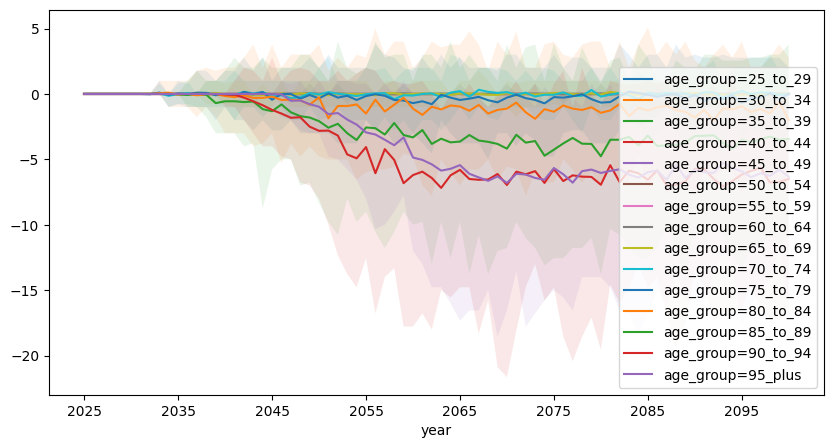

In [224]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(averted_deaths.query(
    "scenario == 'bbbm_testing_and_treatment' and entity == 'other_causes'"
    f" and location=={locations[0]!r}"
    ),
    'age_group'
)
ax.set_xticks(ax.get_xticks()[::10])
plt.show()


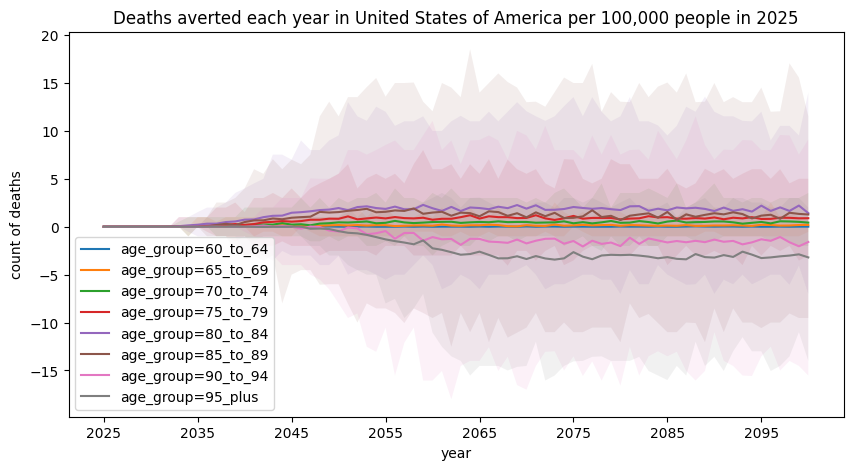

In [237]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="count of deaths",
    title=f"Deaths averted each year in {locations[0]} per 100,000 people in 2025"
)
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

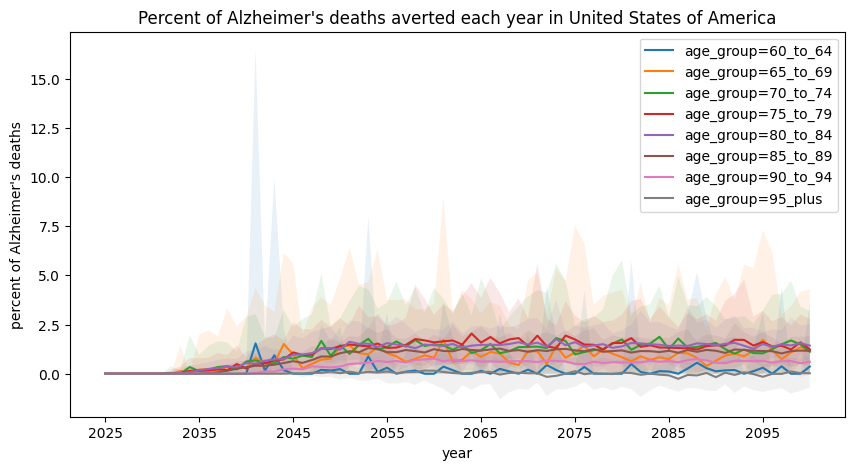

In [227]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="percent of Alzheimer's deaths",
    title=f"Percent of Alzheimer's deaths averted each year in {locations[0]}"
)
ax.set_xticks(ax.get_xticks()[::10])
plt.show()

In [203]:
deaths.scenario.unique()

['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

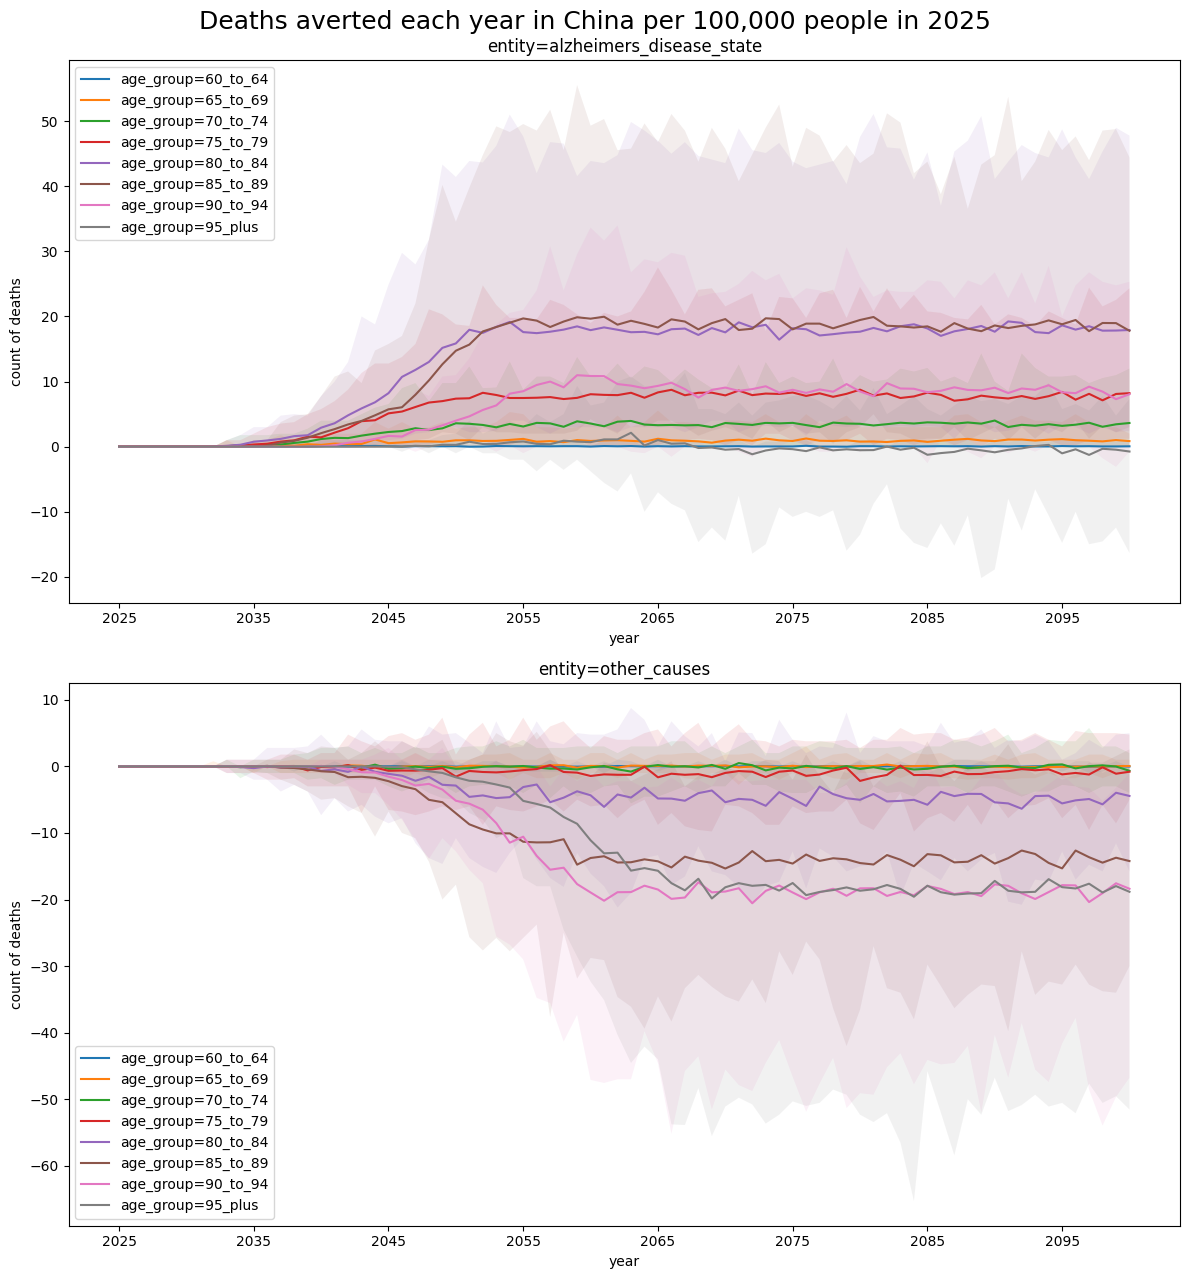

In [232]:
location = locations[1]
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="count of deaths",
    suptitle=f"Deaths averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::10])
plt.show()

# Absolute reductions in AD deaths for all countries

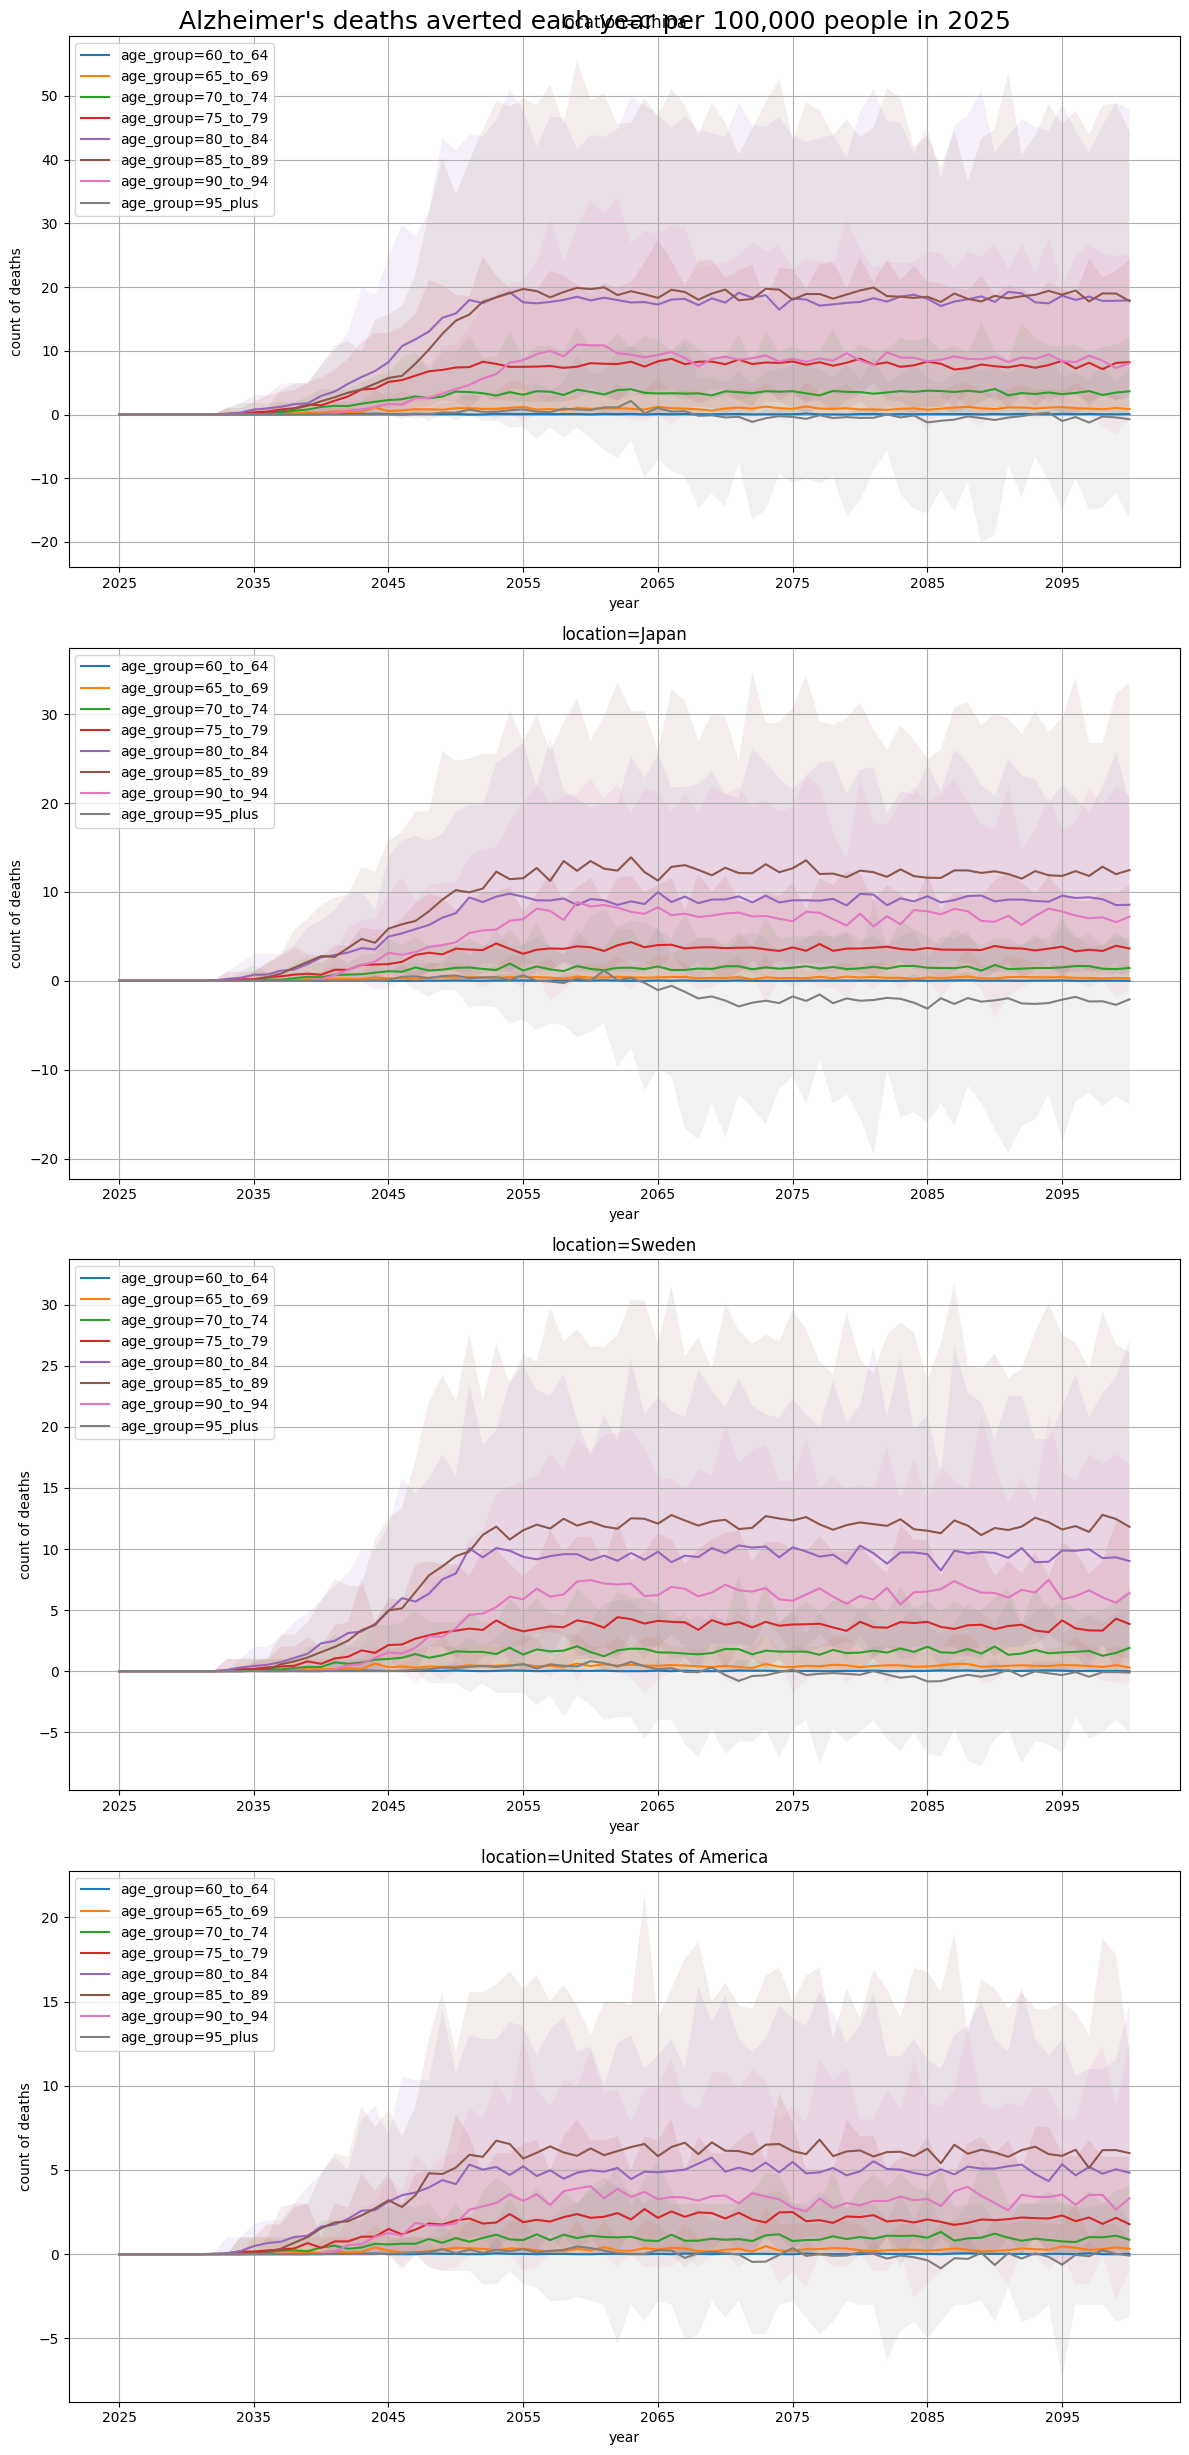

In [235]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="count of deaths",
    suptitle=f"Alzheimer's deaths averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Percent reductions in deaths for all countries

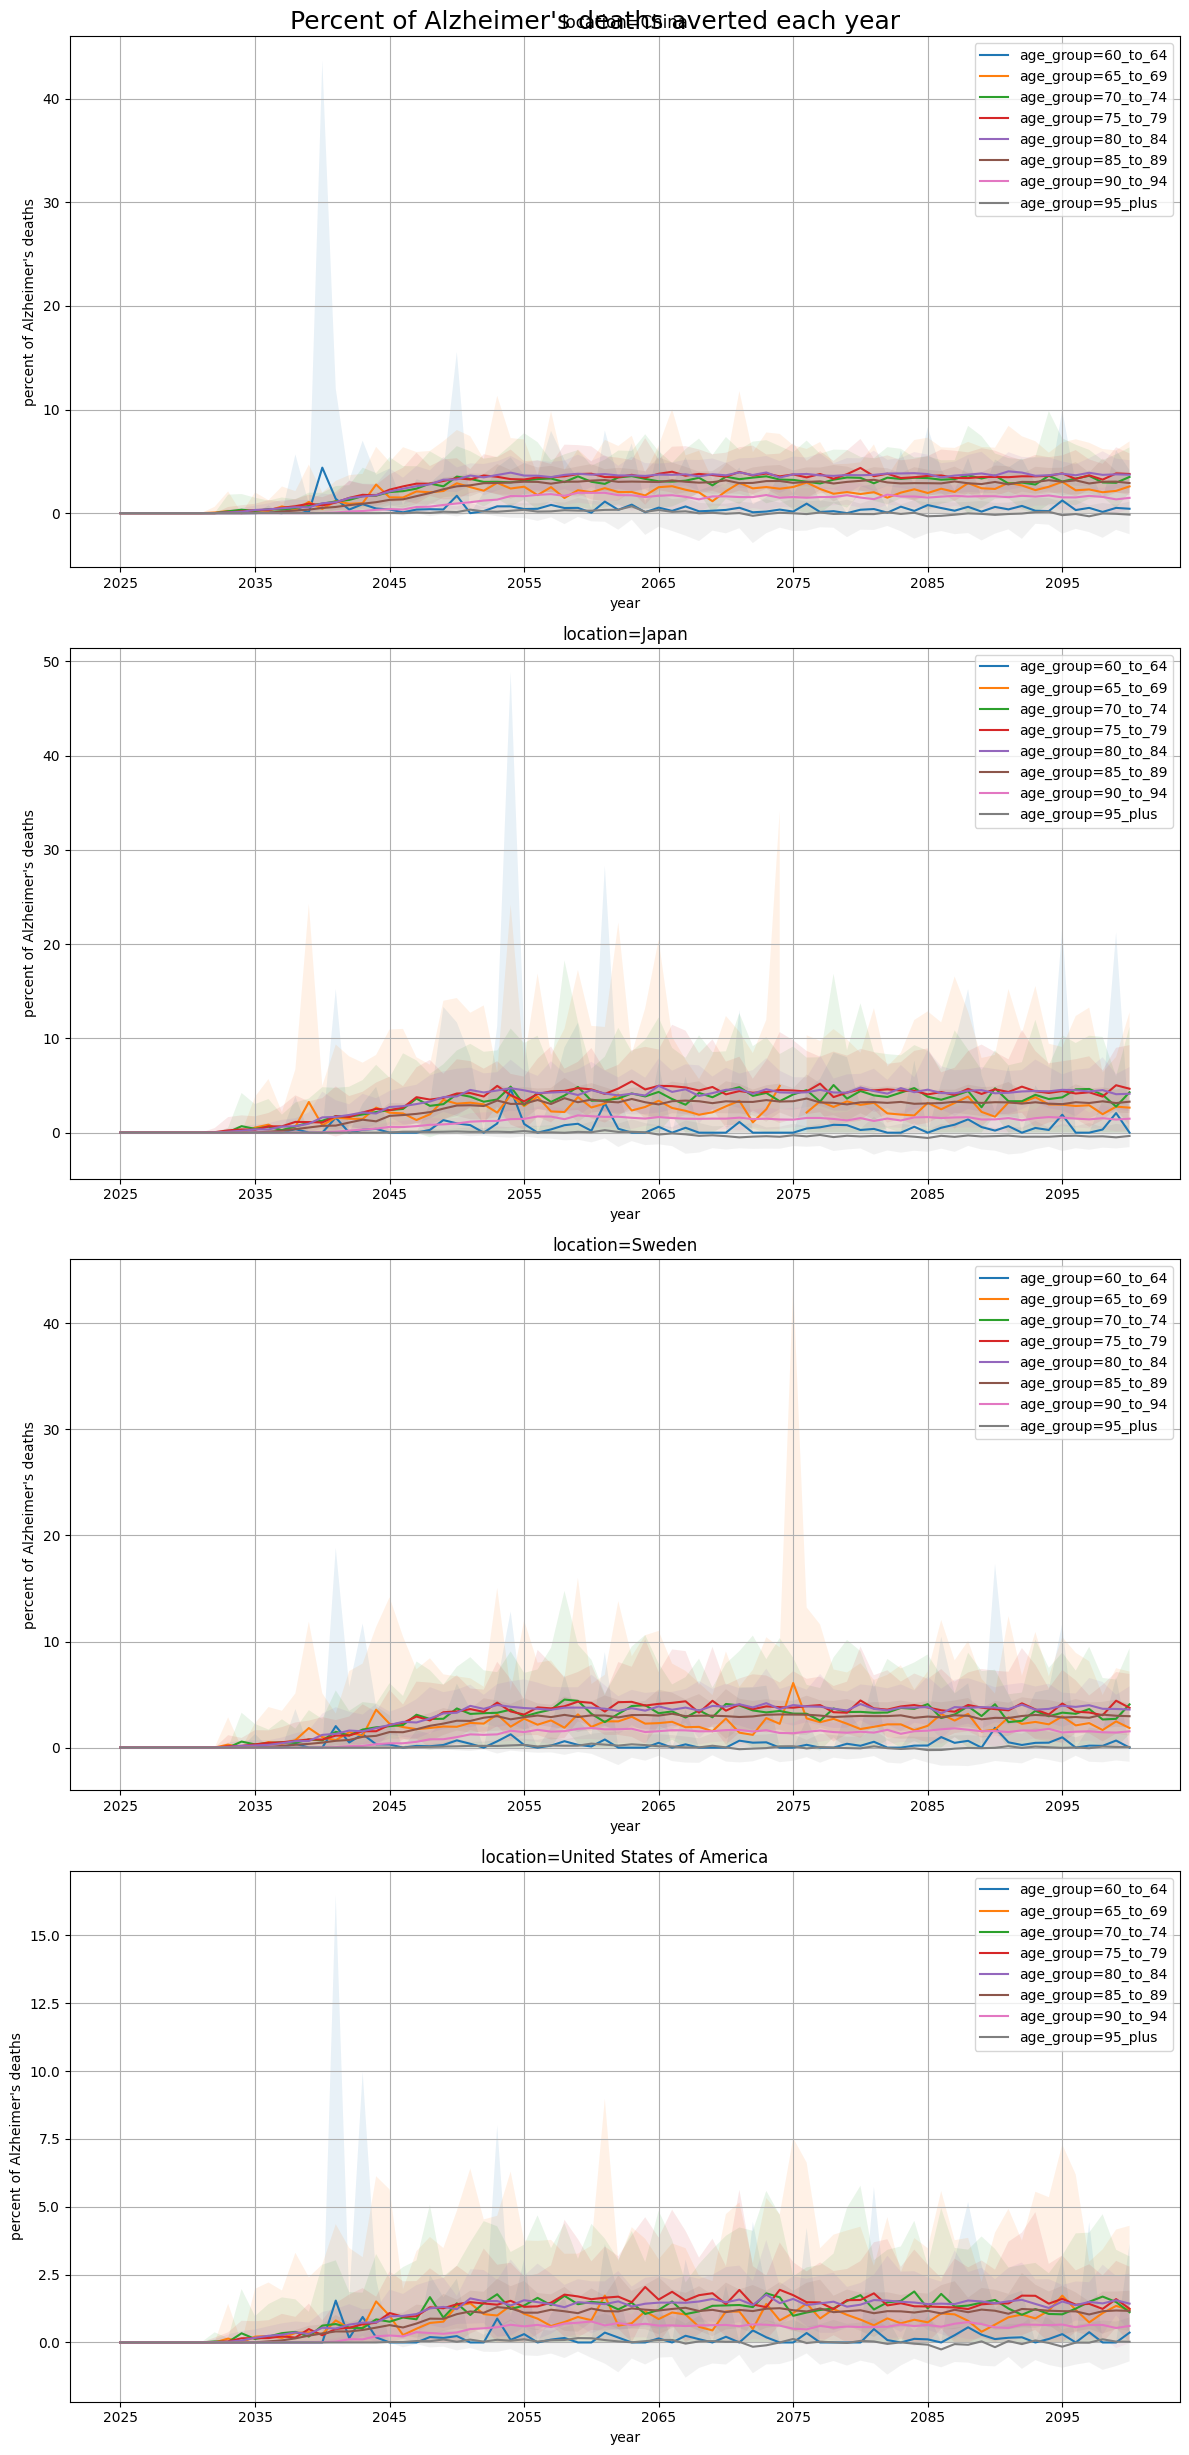

In [234]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="percent of Alzheimer's deaths",
    suptitle=f"Percent of Alzheimer's deaths averted each year"
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Try loading YLDs

In [ ]:
ylds = load_sim_output('ylds')
print_memory_usage(ylds)
ylds

39.00167 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,sub_entity,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,113,ylds,baseline,Female,alzheimers_blood_based_biomarker_state,0.000000,United States of America
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,113,ylds,baseline,Female,alzheimers_mild_cognitive_impairment_state,0.010383,United States of America
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,113,ylds,baseline,Female,alzheimers_disease_state,0.000000,United States of America
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,113,ylds,baseline,Male,alzheimers_blood_based_biomarker_state,0.000000,United States of America
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_and_other_dementias,cause,2025,113,ylds,baseline,Male,alzheimers_mild_cognitive_impairment_state,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...
2051995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,all_causes,cause,2100,460,ylds,baseline,Male,all_causes,362.689151,United States of America
2051996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,all_causes,cause,2100,460,ylds,bbbm_testing,Female,all_causes,1013.257277,United States of America
2051997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,all_causes,cause,2100,460,ylds,bbbm_testing,Male,all_causes,362.689151,United States of America
2051998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,all_causes,cause,2100,460,ylds,bbbm_testing_and_treatment,Female,all_causes,1014.162267,United States of America


In [240]:
averted_ylds = ops.averted(ylds, baseline_scenario='baseline')
print_memory_usage(averted_ylds)
convert_dtypes(averted_ylds, colname_to_categorical_dtype, inplace=True)
print_memory_usage(averted_ylds)
convert_to_categorical(averted_ylds, inplace=True)
print_memory_usage(averted_ylds)

1086.443257 MB
889.544427 MB
27.372526 MB


In [241]:
1086.443257 / 27.372526

39.69101196579373

In [ ]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="count of deaths",
    suptitle=f"Alzheimer's deaths averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()